# Introduction to Spark

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWjZO3synb8bvCp09EZYGBRpQwHqBrAbzeklZop4_ckVZ7NuLHkZFH0
Mounted at /content/drive


In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"
import findspark
findspark.init()

## Basic initialization

In [5]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

matplotlib.style.use('ggplot')
spark = SparkSession.builder.getOrCreate()

We can see that the session is established.

## 1

In [153]:
file_path = "drive/MyDrive/"

In [154]:
countries = spark.read.csv(file_path+"countries of the world.csv",header=True)
print(countries.show(5))

+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|        Country|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|
+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|   Afghanistan |ASIA (EX. NEAR EA...|  31056997|        647500|            

In [155]:
countries.createOrReplaceTempView("countries")

In [156]:
richest = spark.sql("""SELECT Country, `GDP ($ per capita)`, `Infant mortality (per 1000 births)`, `Literacy (%)`
 FROM countries WHERE (`GDP ($ per capita)` IS NOT NULL AND `Infant mortality (per 1000 births)` IS NOT NULL AND `Literacy (%)` IS NOT NULL) 
  ORDER BY Int(`GDP ($ per capita)`) DESC LIMIT 30""")

poorest = spark.sql("""SELECT Country, `GDP ($ per capita)`, `Infant mortality (per 1000 births)`, `Literacy (%)`
 FROM countries WHERE (`GDP ($ per capita)` IS NOT NULL AND `Infant mortality (per 1000 births)` IS NOT NULL AND `Literacy (%)` IS NOT NULL)
  ORDER BY Int(`GDP ($ per capita)`) LIMIT 30""")

In [157]:
from pyspark.sql.functions import regexp_replace

In [158]:
poorest = poorest.withColumn("mortality_vs_literacy",
        (regexp_replace(F.col("Infant mortality (per 1000 births)"), ',', '')) / (regexp_replace(F.col("Literacy (%)"), ',', ''))).toPandas()

richest = richest.withColumn("mortality_vs_literacy",
        (regexp_replace(F.col("Infant mortality (per 1000 births)"), ',', '')) / (regexp_replace(F.col("Literacy (%)"), ',', ''))).toPandas()

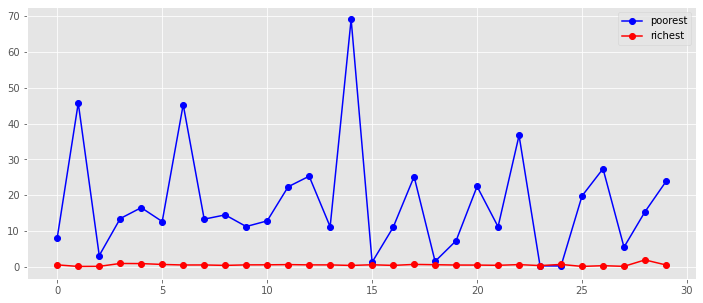

In [159]:
plt.figure(figsize=(12,5))
plt.plot(poorest["mortality_vs_literacy"], 'bo-', label='poorest')
plt.plot(richest["mortality_vs_literacy"], 'ro-', label='richest')
plt.legend()
plt.show()

# 2

In [16]:
airports = spark.read.csv(file_path+"airports.csv", header=False)

In [17]:
airports.show(5)

+---+--------------------+------------+----------------+---+----+------------------+------------------+----+---+----+--------------------+-------+-----------+
|_c0|                 _c1|         _c2|             _c3|_c4| _c5|               _c6|               _c7| _c8|_c9|_c10|                _c11|   _c12|       _c13|
+---+--------------------+------------+----------------+---+----+------------------+------------------+----+---+----+--------------------+-------+-----------+
|  1|      Goroka Airport|      Goroka|Papua New Guinea|GKA|AYGA|-6.081689834590001|     145.391998291|5282| 10|   U|Pacific/Port_Moresby|airport|OurAirports|
|  2|      Madang Airport|      Madang|Papua New Guinea|MAG|AYMD|    -5.20707988739|     145.789001465|  20| 10|   U|Pacific/Port_Moresby|airport|OurAirports|
|  3|Mount Hagen Kagam...| Mount Hagen|Papua New Guinea|HGU|AYMH|-5.826789855957031|144.29600524902344|5388| 10|   U|Pacific/Port_Moresby|airport|OurAirports|
|  4|      Nadzab Airport|      Nadzab|Papua N

In [18]:
cols = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'zone', 'Type', 'Source']
airports = airports.toDF(*cols)

In [28]:
# choosen_airports = airports.sample(fraction=0.01).limit(50)['Latitude', 'Longitude'].toPandas()

In [32]:
latitudes = airports.select("Latitude").rdd.flatMap(lambda x: x).collect()

longitudes = airports.select("Longitude").rdd.flatMap(lambda x: x).collect()

In [49]:
latitudes = list(map(float, latitudes))
longitudes = list(map(float, longitudes))

In [50]:
# !pip install https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap

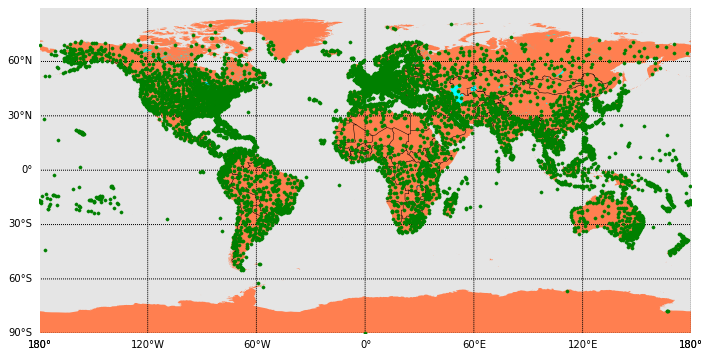

In [55]:
plt.figure(figsize=(12, 6))
my_map = Basemap( resolution = 'l', area_thresh = 10.0,
              lat_0=0, lon_0=0)
something = my_map.scatter(longitudes, latitudes, latlon=True, marker='o', color='g', s=10, zorder=20)
my_map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
my_map.drawmeridians(np.arange(my_map.lonmin,my_map.lonmax,60),labels=[0,0,0,1])
my_map.fillcontinents(color='coral',lake_color='aqua')
my_map.drawcountries()

plt.show()

# 3

In [138]:
countries.show(5)

+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+-----------------+-----------------------+
|        Country|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|     Area (sq mi)|Pop Density (per sq mi)|
+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-

In [77]:
countries = countries.withColumn("Area (sq mi)",
        F.col("`Area (sq. mi.)`") * 2.59)

In [78]:
countries = countries.withColumn("Pop Density (per sq mi)",
        (F.col("Population")) / (F.col("Area (sq mi)")))

In [79]:
countries.show(5)

+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+-----------------+-----------------------+
|        Country|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|     Area (sq mi)|Pop Density (per sq mi)|
+---------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-

# 4

In [142]:
from pyspark.sql.functions import udf

In [191]:
strip = lambda x: x.strip()

strip_udf = udf(strip)

countries = countries.withColumn("Country", strip_udf(F.col("Country")))

In [192]:
countries.show(5)

+--------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|       Country|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|
+--------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|   Afghanistan|ASIA (EX. NEAR EA...|  31056997|        647500|                

In [193]:
countries_airports = airports.join(countries, ['Country'], 'outer')

In [194]:
countries_airports.createOrReplaceTempView("countries_airports")

In [195]:
only_countries = spark.sql("SELECT Country FROM countries_airports WHERE `Airport ID` IS NULL").toPandas()
only_airports = spark.sql("SELECT DISTINCT Country FROM countries_airports WHERE `Region` IS NULL").toPandas()

In [196]:
only_countries

,Country
0,"Congo, Repub. of the"
1,"Congo, Dem. Rep."
2,Central African Rep.
3,San Marino
4,"Micronesia, Fed. St."
5,Andorra
6,N. Mariana Islands
7,Liechtenstein
8,"Gambia, The"
9,Gaza Strip


In [197]:
only_airports

,Country
0,British Indian Ocean Territory
1,Norfolk Island
2,Northern Mariana Islands
3,Turks and Caicos Islands
4,British Virgin Islands
5,Myanmar
6,Bahamas
7,Sao Tome and Principe
8,Saint Pierre and Miquelon
9,Congo (Kinshasa)


In [198]:
airports = airports.withColumn('Country', regexp_replace('Country', 'North Korea', 'Korea, North'))
airports = airports.withColumn('Country', regexp_replace('Country', 'South Korea', 'Korea, South'))
airports = airports.withColumn('Country', regexp_replace('Country', 'Congo (Kinshasa)', 'Congo, Dem. Rep.'))

In [199]:
countries_airports = airports.join(countries, ['Country'], 'inner')
countries_airports.createOrReplaceTempView("countries_airports")

In [200]:
countries_airports.show()

+----------------+----------+--------------------+--------------+----+----+------------------+-------------------+--------+--------+---+--------------------+-------+-----------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|         Country|Airport ID|                Name|          City|IATA|ICAO|          Latitude|          Longitude|Altitude|Timezone|DST|                zone|   Type|     Source|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|
+----------------+----------+--------------------+--------------

In [207]:
airports_by_country = spark.sql("SELECT MAX(FLOAT(`Area (sq. mi.)`)) AS Area, COUNT(Country) AS Airports FROM countries_airports WHERE `Area (sq. mi.)` IS NOT NULL GROUP BY Country ORDER BY Area").toPandas()

In [212]:
airports_by_country

,Area,Airports
0,7.0,1
1,21.0,1
2,26.0,1
3,28.0,1
4,53.0,1
...,...,...
202,8511965.0,234
203,9596960.0,180
204,9631420.0,1435
205,9984670.0,417


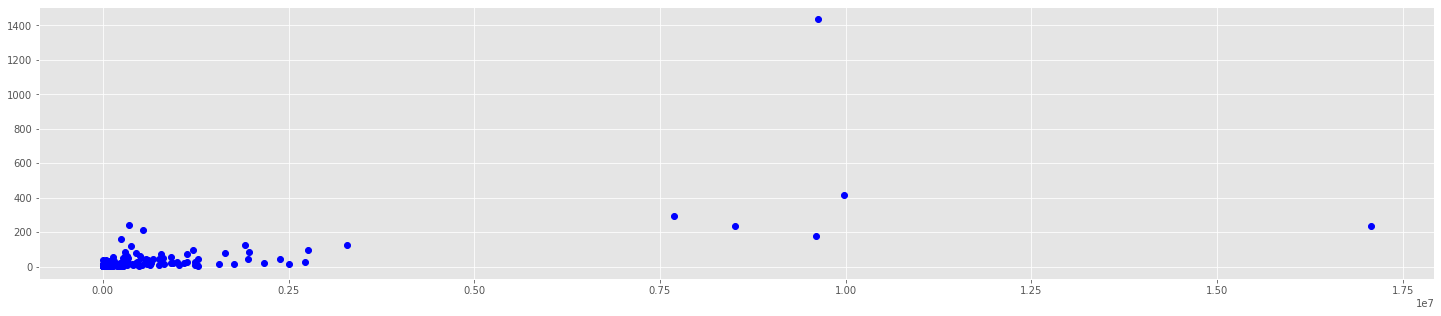

In [215]:
plt.figure(figsize=(25,5))
plt.plot(airports_by_country['Area'], airports_by_country['Airports'], 'bo')
plt.show()

# 5

In [217]:
countries_airports.show(5)

+----------------+----------+--------------------+------------+----+----+------------------+------------------+--------+--------+---+--------------------+-------+-----------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|         Country|Airport ID|                Name|        City|IATA|ICAO|          Latitude|         Longitude|Altitude|Timezone|DST|                zone|   Type|     Source|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|
+----------------+----------+--------------------+------------+----+--

In [238]:
spark.sql("SELECT DISTINCT Region FROM countries_airports").show()

+--------------------+
|              Region|
+--------------------+
|BALTICS          ...|
|C.W. OF IND. STATES |
|ASIA (EX. NEAR EA...|
|WESTERN EUROPE   ...|
|NORTHERN AMERICA ...|
|NEAR EAST        ...|
|EASTERN EUROPE   ...|
|OCEANIA          ...|
|SUB-SAHARAN AFRIC...|
|NORTHERN AFRICA  ...|
|LATIN AMER. & CAR...|
+--------------------+



In [247]:
def continent(region):
  region = region.strip()
  if region in ["BALTICS", "WESTERN EUROPE", "EASTERN EUROPE"]:
    return 'Europe'
  elif region in ["C.W. OF IND. STATES", "ASIA (EX. NEAR EAST)", "NEAR EAST"]:
    return 'Asia'
  elif region in ["NORTHERN AMERICA"]:
    return 'North America'
  elif region in ["LATIN AMER. & CARIB"]:
    return 'South America'
  elif region in ["OCEANIA"]:
    return 'Australia/Oceania'
  elif region in ["SUB-SAHARAN AFRICA", "NORTHERN AFRICA"]:
    return 'Asia'

continent_udf = udf(continent)

countries_airports = countries_airports.withColumn("Continent", continent_udf(F.col("Region")))

countries_airports.createOrReplaceTempView("countries_airports")

In [248]:
countries_airports.show(5)

+----------------+----------+--------------------+------------+----+----+------------------+------------------+--------+--------+---+--------------------+-------+-----------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+-----------------+
|         Country|Airport ID|                Name|        City|IATA|ICAO|          Latitude|         Longitude|Altitude|Timezone|DST|                zone|   Type|     Source|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|        Continent|
+----------------+----------+-----

In [249]:
airports_by_continent = spark.sql("SELECT MAX(Continent) AS Continent, COUNT(Continent) AS Airports FROM countries_airports WHERE Continent IS NOT NULL GROUP BY Continent").toPandas()

In [250]:
airports_by_continent

,Continent,Airports
0,Europe,1391
1,Australia/Oceania,542
2,North America,1875
3,South America,921
4,Asia,2317


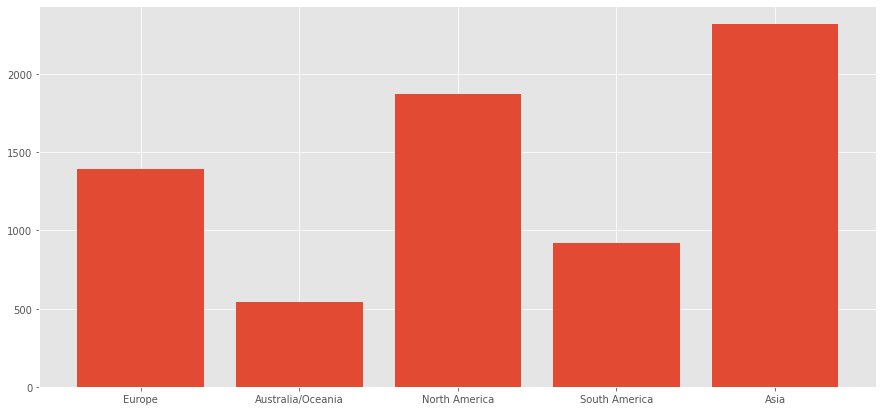

In [253]:
plt.figure(figsize = (15,7))
plt.bar(airports_by_continent['Continent'], airports_by_continent['Airports'])
plt.show()